In [ ]:
from google.colab import drive
drive.mount('/content/drive')
URL = "/content/drive/MyDrive/235757_HAICon2021_dataset.zip (Unzipped Files)"

Mounted at /content/drive


In [ ]:
!pip install ./eTaPR-21.8.2-py3-none-any.whl

Processing ./eTaPR-21.8.2-py3-none-any.whl
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/content/eTaPR-21.8.2-py3-none-any.whl'



In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange
#from TaPR_pkg import etapr
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import time
from scipy import signal

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:

TRAIN_DATASET = sorted([x for x in Path(URL+"/train/").glob("*.csv")])
TRAIN_DATASET

VALIDATION_DATASET = sorted([x for x in Path(URL+"/validation/").glob("*.csv")])
VALIDATION_DATASET

TEST_DATASET = sorted([x for x in Path(URL+"/test/").glob("*.csv")])
TEST_DATASET

[PosixPath('/content/drive/MyDrive/235757_HAICon2021_dataset.zip (Unzipped Files)/test/test1.csv'),
 PosixPath('/content/drive/MyDrive/235757_HAICon2021_dataset.zip (Unzipped Files)/test/test2.csv'),
 PosixPath('/content/drive/MyDrive/235757_HAICon2021_dataset.zip (Unzipped Files)/test/test3.csv')]

In [ ]:
def dataframe_from_csv(target):
    return pd.read_csv(target, engine='python').rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [ ]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,50,11704,17.61017,28.03686,27170,27.24188,25.42843,0,1,50,27.28778,31.02721,1,267.90363,467.27020,3865,50,14742,0.88504,1,54816,1009.15302,58.21227,5.5352,0,126.92957,2880,26.92264,0,0,...,48.64655,1,0,13752,41.81518,1,0.14465,0.46783,0,276.45758,476.76703,8.90254,49.26452,719.96625,1,923,0,0,16,0.08771,15.07713,9914,1,306.07104,28.20367,15.50464,251.23593,451.06253,26.13983,48.90190,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,50,11847,17.61780,28.03169,27171,27.24188,25.42656,0,1,50,27.28778,31.01196,1,268.95258,466.91238,3898,50,14781,0.88619,1,54816,1011.06647,57.44932,4.7507,0,126.92957,2880,26.92264,0,0,...,50.40893,1,0,13752,41.81518,1,0.14465,0.42892,0,278.91705,476.76703,8.90254,49.26452,720.10663,1,923,0,0,16,0.08771,14.97197,9914,1,303.09189,28.19449,16.20023,250.47298,404.38739,26.13983,48.94870,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,50,11953,17.61780,28.03504,27170,27.24188,25.41979,0,1,50,27.28778,31.01196,1,269.76636,466.91238,3892,50,14831,0.88836,1,54816,1009.79083,58.78445,5.5709,0,126.92957,2880,26.92264,0,0,...,50.60730,1,0,13760,41.81518,1,0.14465,0.42282,0,278.89899,476.76703,8.90254,49.26452,719.96625,1,923,0,0,16,0.08771,14.90129,9914,1,299.11945,28.18530,16.53352,249.90080,382.53925,26.14746,48.89090,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,50,12051,17.61780,28.03510,27171,27.24188,25.44255,0,1,50,27.28778,31.01196,1,271.64716,466.35010,3876,50,14917,0.89214,1,54816,1008.77380,59.16594,5.1828,0,126.92957,2880,26.92264,0,0,...,49.14246,1,0,13760,41.81518,1,0.14465,0.43121,0,280.49048,476.76703,8.90254,49.26452,720.00159,1,923,0,0,16,0.08771,14.82246,9914,1,306.07104,28.17612,16.30247,250.47298,396.44250,26.13983,48.95938,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,50,12180,17.61780,28.03510,27171,27.24188,25.44007,0,1,50,27.28778,31.02721,1,272.80457,466.60565,3871,50,14997,0.89191,1,54815,1009.79083,58.78445,5.1828,0,126.92957,2880,26.92264,0,0,...,47.18170,1,0,13760,41.81518,1,0.14465,0.45486,0,283.47437,476.76703,8.90254,49.26452,720.00159,1,923,0,0,16,0.08771,14.73087,9914,1,308.05728,28.16693,15.79237,250.28227,427.22849,26.13983,49.02211,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,2021-08-09 08:59:56,-2.0065,0,12.26196,0.00051,100.28228,0.5977,12.53358,70,1,50,8536,13.45978,28.03433,27213,27.75778,37.62007,0,1,50,27.70997,31.40868,1,318.30511,465.27664,2,50,17293,1.08731,1,54740,991.81366,58.78445,5.7302,0,112.42368,2880,31.38997,0,0,...,12.39929,1,0,0,36.39832,1,64.39886,0.36179,0,307.83423,459.18994,4.67615,49.62311,720.04309,1,905,0,0,13856,0.13800,100.00000,10000,1,308.05728,35.00000,100.00000,242.46214,3175.36084,38.49182,48.07038,1.17355,35.05434,10.00000,3178.48877,370.02679,1,986.05908,12.0,50,136
259196,2021-08-09 08:59:57,-2.2101,0,12.26196,-0.00029,100.28228,0.5509,12.53358,70,1,50,8519,13.45978,28.03521

In [ ]:
def plot(column, s=10):
    plt.figure(figsize=(20, 4))
    plt.title(column)
    plt.scatter(pd.to_datetime(TRAIN_DF['timestamp']), TRAIN_DF[column], color='k',       s=s, label='Train'  )

    plt.xlabel('Date')
    plt.show()

In [ ]:
# DROP_FIELD = ['C01', 'C06', 'C13', 'C14', 'C15', 'C20', 'C21', 'C23', 'C27', 'C28', 
#               'C31', 'C33', 'C37', 'C41', 'C56', 'C57', 'C58', 'C59', 'C66', 'C73', 'C79', 'C83',
#               'timestamp']

# DROP_FIELD2 = ['C01', 'C06', 'C13', 'C14', 'C15', 'C20', 'C21', 'C23', 'C27', 'C28', 
#               'C31', 'C33', 'C37', 'C41', 'C56', 'C57', 'C58', 'C59', 'C66', 'C73', 'C79', 'C83'
#               ]              

In [ ]:
# USE_FIELD = ['C03', 'C11', 'C24', 'C25', 'C30', 'C50', 'C59', 'C62', 'C84', 'C86']
# USE_FIELD2 =  ['C01', 'C06', 'C33', 'C41', 'C44'] # 깔끔 (기존꺼 모두 있음)
# USE_FIELD3 =  ['C31', 'C32', 'C59', 'C70', 'C73', 'C76', 'C83'] # 잘잡히는 편 (새로 3개나 잡힘) (#1)
# USE_FIELD4 = ['C30', 'C48', 'C61', 'C62'] #깔끔한편 
# USE_FIELD5 = ['C14', 'C21', 'C37', 'C78'] #공격이 없어보임
# USE_FIELD6 = ['C23', 'C27', 'C28', 'C53', 'C56', 'C65', 'C81'] # 하나 기존꺼 정도
# USE_FIELD7 = ['C17', 'C34', 'C64'] # 공격 없음
USE_FIELD8 = ['C45', 'C47', 'C51'] # 두개 찾음(#2)
# USE_FIELD9 = ['C25', 'C50', 'C86'] # 242 부근 
# USE_FIELD10 = ['C05', 'C14', 'C21', 'C37', 'C40', 'C67', 'C72', 'C74', 'C78', 'C80']
# USE_FIELD11 = ['C68', 'C77'] # 확실히 아님
# USE_FIELD12 =['C84']
# USE_FIELD13 =['C03']
# USE_FIELD14 =['C35']
# USE_FIELD15 = ['C12', 'C31', 'C32', 'C43', 'C70', 'C73', 'C83']
# USE_FIELD16 = ['C50', 'C86'] #3
USE_FIELD17 = ['C31','C73','C83','C59','C76']
#USE_FIELD18 = ['C47', 'C51']
# 3, 6, 16

In [ ]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
#VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop(DROP_FIELD)
#다음에 10해보기
VALID_COLUMNS_IN_TRAIN_DATASET = USE_FIELD17
VALID_COLUMNS_IN_TRAIN_DATASET

['C31', 'C73', 'C83', 'C59', 'C76']

In [ ]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [ ]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [ ]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    print(x)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [ ]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [ ]:
boundary_check(TRAIN_DF)

[[0.51311845 0.443864   0.538147   0.2419619  0.24685518]
 [0.51988065 0.43864197 0.538147   0.2419619  0.24891865]
 [0.5153725  0.4347257  0.538147   0.2419619  0.24637017]
 ...
 [0.45337686 0.39033917 0.41419157 0.25787213 0.20735718]
 [0.4595246  0.38381186 0.41419157 0.25787213 0.20304416]
 [0.45184022 0.38511717 0.41419157 0.25654623 0.20567246]]


(False, False, False)

In [ ]:
train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(1004402, 1, 5)

In [ ]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session()

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=128, kernel_size=48, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense(128),
            layers.Bidirectional(layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            )),
            layers.RepeatVector(n_steps),
            layers.Bidirectional(layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            )),
            layers.Dense(128),
            layers.Conv1D(filters=128, kernel_size=48, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
        ]
    )
    return model

In [ ]:

model = conv_auto_model(x_train)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 128)            30848     
_________________________________________________________________
dense (Dense)                (None, 1, 128)            16512     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 128)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 128)            98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 128)            7

In [ ]:

modelpath = URL+"/"+"_".join(VALID_COLUMNS_IN_TRAIN_DATASET)+"ae_{epoch:02d}-{val_loss:.8f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

epochs = 50
batch = 64

# fit
history = model.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2, callbacks=[checkpointer, early_stopping_callback]).history

Epoch 1/50
12556/12556 [==============================] - 197s 14ms/step - loss: 2.7130e-04 - val_loss: 8.4681e-06

Epoch 00001: val_loss improved from inf to 0.00001, saving model to /content/drive/MyDrive/235757_HAICon2021_dataset.zip (Unzipped Files)/C31_C73_C83_C59_C76ae_01-0.00000847.hdf5
Epoch 2/50
12556/12556 [==============================] - 176s 14ms/step - loss: 1.1856e-05 - val_loss: 7.2892e-06

Epoch 00002: val_loss improved from 0.00001 to 0.00001, saving model to /content/drive/MyDrive/235757_HAICon2021_dataset.zip (Unzipped Files)/C31_C73_C83_C59_C76ae_02-0.00000729.hdf5
Epoch 3/50
12556/12556 [==============================] - 176s 14ms/step - loss: 6.5649e-06 - val_loss: 5.7993e-06

Epoch 00003: val_loss improved from 0.00001 to 0.00001, saving model to /content/drive/MyDrive/235757_HAICon2021_dataset.zip (Unzipped Files)/C31_C73_C83_C59_C76ae_03-0.00000580.hdf5
Epoch 4/50
12556/12556 [==============================] - 175s 14ms/step - loss: 5.0875e-06 - val_loss: 2.3

KeyboardInterrupt: ignored

In [ ]:
model.save(URL+"/models/"+"_".join(USE_FIELD8)+'.h5')

# test

In [ ]:
model = load_model(URL+'/models/제출용/그룹4 모델.hdf5')

In [ ]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,50,11876,11.68213,28.03598,26979,28.46628,27.40174,0,1,50,27.66017,29.02832,1,298.73773,425.30319,3609,50,16454,1.06824,1,54718,980.07202,51.53651,5.6482,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12848,48.20861,1,0.75955,0.32135,0,335.30457,425.87881,6.93170,49.85962,719.92224,1,905,0,0,144,0.18680,9.57111,9972,1,268.33344,35.0,8.72313,236.93082,229.60286,27.68860,48.60640,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,50,12094,11.68213,28.03169,26981,28.46628,27.45389,0,1,50,27.66017,29.04358,1,303.80133,425.40543,3656,50,16713,1.08312,1,54719,979.20227,52.49024,5.4256,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12896,48.17810,1,0.68719,0.32211,0,340.47668,425.87881,6.93170,49.85962,720.02686,1,905,0,0,144,0.18680,9.60827,9972,1,273.29919,35.0,8.77705,237.31230,229.60286,27.68860,48.62812,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,50,12137,11.68213,28.03251,26983,28.46628,27.49862,0,1,50,27.66017,29.04358,1,309.17242,425.40543,3676,50,17022,1.09502,1,54718,980.07202,51.53651,5.1649,0,108.60724,2880,25.66094,0,0,...,97.24579,1,0,12944,48.16284,1,0.63293,0.31906,0,348.79559,425.87881,6.93170,49.85962,720.06177,1,905,0,0,128,0.18680,9.66742,9972,1,268.33344,35.0,8.93085,237.88448,222.65125,27.68860,48.66984,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,50,12187,11.68213,28.03251,26985,28.46628,27.56569,0,1,50,27.66017,29.05884,1,313.42230,425.50763,3719,50,17233,1.11219,1,54718,981.37659,51.72729,5.1649,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12984,48.13232,1,0.61487,0.32593,0,355.12512,425.87881,6.93170,49.85962,720.06177,1,905,0,0,112,0.18680,9.70509,9972,1,269.32672,35.0,8.91705,237.88448,227.61664,27.68097,48.64198,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,50,12198,11.68213,28.03081,26979,28.46628,27.56569,0,1,50,27.66017,29.05884,1,318.25092,424.94534,3725,50,17493,1.11219,1,54718,979.63727,52.10876,4.8932,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12696,48.11707,1,0.56064,0.32364,0,358.27185,425.87881,6.93170,49.85962,720.09613,1,906,0,0,96,0.18680,9.77965,9972,1,271.31296,35.0,8.91705,237.12160,230.59618,27.68097,48.59238,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,50,16228,18.91479,28.03953,26971,27.86075,28.35412,0,1,50,27.76649,28.95202,1,327.31122,460.57385,386,50,17966,1.04908,1,54718,1010.42865,61.45473,7.1499,0,108.24304,2880,25.68717,0,0,...,28.19976,1,0,4944,35.02502,1,36.85620,1.07132,0,318.08813,467.03854,26.76094,49.89013,719.98303,1,904,0,0,8384,0.06944,29.89865,9917,1,319.97427,35.0,14.31306,250.85446,981.37659,27.83356,49.44022,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,50,16108,19.18945,28.03953,26970,27.86075,28.47250,0,1,50,27.76649,2

In [ ]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [ ]:
boundary_check(TEST_DF)

[[0.41034466 0.34595278 0.39396137 0.2678157  0.23382616]
 [0.4072709  0.34856382 0.39396137 0.2678157  0.23478383]
 [0.41034466 0.35248008 0.39396137 0.2678157  0.23662332]
 ...
 [0.51649976 0.43994775 0.5393395  0.2691412  0.27110237]
 [0.51649976 0.443864   0.5393395  0.2691412  0.27304593]
 [0.51988065 0.44778034 0.5393395  0.2691412  0.27214912]]


(False, True, False)

In [ ]:


test = np.array(TEST_DF)
x_test = test.reshape(test.shape[0], 1, test.shape[1])
x_test.shape

(274800, 1, 5)

In [ ]:
start = time.time()
test_x_predictions = model.predict(x_test)
#print(test_x_predictions)
print(test_x_predictions.shape)
#print((flatten(x_test) - flatten(test_x_predictions)).shape)
test_mse = np.mean(np.power(flatten(x_test) - flatten(test_x_predictions), 2), axis=1)
print(test_mse.shape)
print(time.time()-start)

(274800, 1, 5)
(274800,)
42.001288414001465


In [ ]:
test_error = pd.DataFrame({'Reconstruction_error': test_mse})

In [ ]:
move = 70
test_move = test_error['Reconstruction_error'].rolling(move, center=True).mean()
#test_move = test_error['Reconstruction_error'].ewm(span = move, adjust = True,alpha = 0.4).mean()
#test_move = test_error['Reconstruction_error'].ewm(span = move,adjust = True).mean()

test_d = test_move.fillna(0)
test_d

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
274795    0.0
274796    0.0
274797    0.0
274798    0.0
274799    0.0
Name: Reconstruction_error, Length: 274800, dtype: float64

In [ ]:
movemean_test = pd.DataFrame({'Reconstruction_error': test_d})

# TEST PREDICT

In [ ]:
submission = pd.read_csv(URL+'/baseline.csv')
submission.index = submission['timestamp']
#submission['attack'] = pred_y_test
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [ ]:
submission['attack'].value_counts()

0.0    272087
1.0      2713
Name: attack, dtype: int64

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    pred_y_test = []
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])

        #Threshold 설정

        pred_tem = [1 if e > THRESHOLD[i] else 0 for e in list(xs[L:R])]
        pred_y_test.extend(pred_tem)

        #SUBPLOT
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            #axs[i].title.set_text(i)
            #axs[i].plot(xticks, att[L:R] * peak * 0.3)
            #axs[i].set_ylim(0,0.01)
        if THRESHOLD!=None:
            axs[i].title.set_text(i)
            axs[i].set_ylim(0,0.00001)
            axs[i].axhline(y=THRESHOLD[i], color='r')
    plt.show()

    pred_y_test
    pred_y_test = np.array(pred_y_test)
    return pred_y_test

In [ ]:
auto_threshold_8 = [
0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,
0.000002,0.000002,0.000003,0.1,0.1,0.1,0.1,0.1,0.1,0.000002,
0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,
0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
]



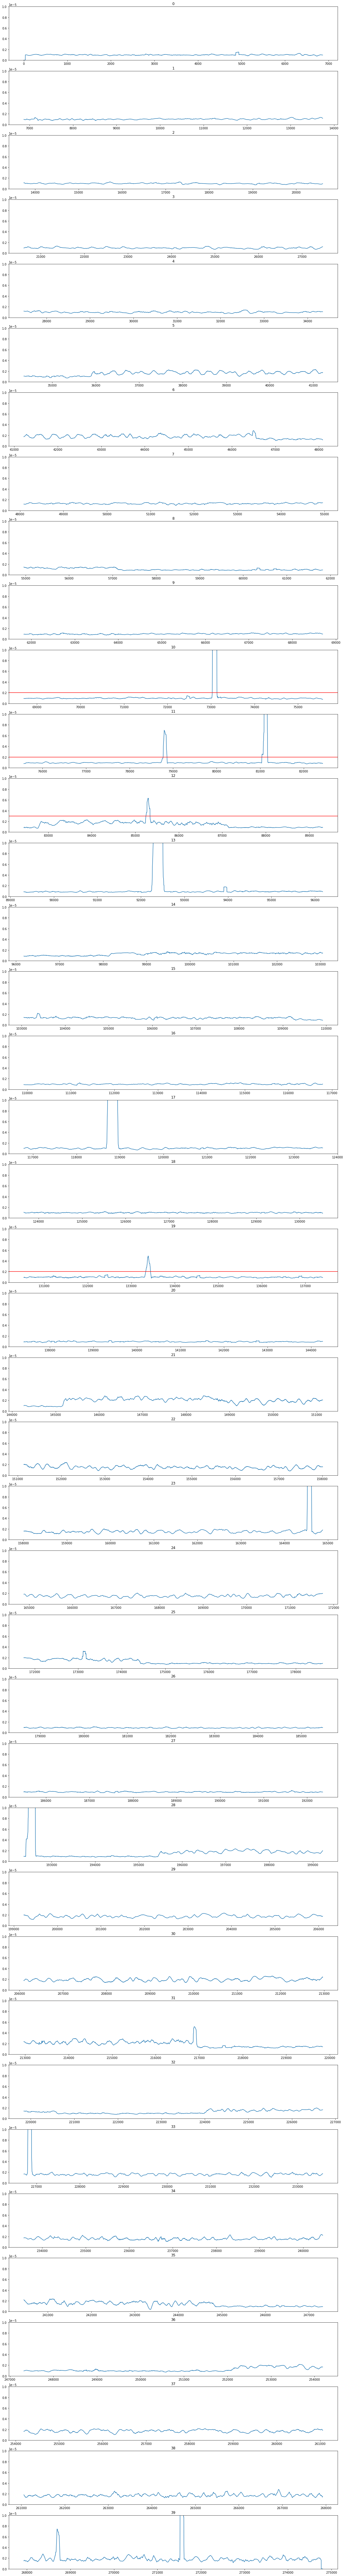

In [ ]:

pred_y_test = check_graph(test_d, submission['attack'], piece=40, THRESHOLD=auto_threshold_8)

In [ ]:
submission = pd.read_csv(URL+'/baseline.csv')
submission.index = submission['timestamp']
submission['attack'] = pred_y_test
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0
2021-07-13 16:00:02,2021-07-13 16:00:02,0
2021-07-13 16:00:03,2021-07-13 16:00:03,0
2021-07-13 16:00:04,2021-07-13 16:00:04,0
2021-07-13 16:00:05,2021-07-13 16:00:05,0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0
2021-07-16 23:59:57,2021-07-16 23:59:57,0
2021-07-16 23:59:58,2021-07-16 23:59:58,0


In [ ]:
submission['attack'].value_counts()

0    274263
1       537
Name: attack, dtype: int64

In [ ]:
submission.to_csv(URL+"/final_csv/추가공격3_private(537).csv",index= False)